In [1]:
from comet_ml import Experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

In [2]:
## Create an experiment with your api key
experiment = Experiment(
    api_key="Q5t8ZJ5IC5PvHbwAugI7xihW4",
    project_name="FeedFoward Neural Network with Voltage",
    workspace="kaioforte",
    auto_histogram_weight_logging=True,
    auto_histogram_gradient_logging=True,
    auto_histogram_activation_logging=True,
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kaioforte/feedfoward-neural-network-with-voltage/8cb8d3a548e248cfb85c8569a58e6190

COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


## Importing the dataset

In [3]:
d = loadmat('dataset/resultados_w1000pts.mat')
ptrafo1 = pd.DataFrame(d['Ptrafo1'].transpose().flatten(), columns = ['Ptrafo1'])
ptrafo2 = pd.DataFrame(d['Ptrafo2'].transpose().flatten(), columns = ['Ptrafo2'])


In [4]:
fv = loadmat('dataset/FVcurves1000pts.mat')
fv_12 = pd.DataFrame(fv['FV_w'].flatten(), columns = ['FV_12'])
fv_18 = pd.DataFrame(fv['FV_w'].flatten(), columns = ['FV_18'])
fv_25 = pd.DataFrame(fv['FV_w'].flatten(), columns = ['FV_25'])
fv_29 = (1/47) * pd.DataFrame(fv['FV_w'].flatten(), columns = ['FV_29'])
fv_32 = (1/42) * pd.DataFrame(fv['FV_w'].flatten(), columns = ['FV_32'])

In [5]:
## Transforming vref to a (144000 x 1) matrix
vref1 = np.zeros([144, 1000])
vref2 = np.zeros([144, 1000])
a = 0
b = 25
for i in range(144):
  for j in range(len(d['Tensao'][0])):
    vref1[i][j] = d['Tensao'][a][j]
    vref2[i][j] = d['Tensao'][b][j]
  a = a + 42
  b = b + 42

vref1 = pd.DataFrame(vref1.transpose().flatten(), columns = ['Vref1'])
vref2 = pd.DataFrame(vref2.transpose().flatten(), columns = ['Vref2'])

In [6]:
## Loading the cargaP/Q to a (42 x 1000 x 144) matrix
## 42 - buses, 1000 - samples, 144 timesteps
cargaP = np.zeros([42, 1000, 144])
cargaQ = np.zeros([42, 1000, 144])
p = d['CargaP'].transpose()
q = d['CargaP'].transpose()

for i in range(42):
  for j in range(1000):
    a = i
    for k in range(144):
      cargaP[i][j][k] = p[j][a]
      cargaQ[i][j][k] = q[j][a]
      a = a + 42

## Creating a averageP/Q array of (144 x 42) by taking the mean value of all 1000 samples
## Repeating it 1000 times to match the 144000 samples of the cargaP/Q array
## Droping the 0th and 25th powers because this represents the transformer reference values
avgP = cargaP.mean(axis=1)
avgQ = cargaQ.mean(axis=1)

avgP = pd.DataFrame(avgP.transpose())
avgP  = pd.concat([avgP]*1000, ignore_index=True)
avgP.columns = [f'P{col_name}' for col_name in avgP.columns]
avgP = avgP.drop(['P0','P25'], axis=1)

avgQ = pd.DataFrame(avgQ.transpose())
avgQ  = pd.concat([avgQ]*1000, ignore_index=True)
avgQ.columns = [f'Q{col_name}' for col_name in avgQ.columns]
avgQ = avgQ.drop(['Q0','Q25'], axis=1)

## Reshaping the original array(42x1000x144) to (42x14000) and transposing it,
## so the columns represent the buses
cargaP = pd.DataFrame(cargaP.reshape(42,144000).transpose())
cargaP.columns = [f'P{col_name}' for col_name in cargaP.columns]
cargaP = cargaP.drop(['P0','P25'], axis=1)

cargaQ = pd.DataFrame(cargaQ.reshape(42,144000).transpose())
cargaQ.columns = [f'Q{col_name}' for col_name in cargaQ.columns]
cargaQ = cargaQ.drop(['Q0','Q25'], axis=1)

cargaP



,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41
0,0.009734,0.009834,0.012679,0.006414,0.005711,0.019901,0.020760,0.005586,0.005986,0.004578,...,0.000216,0.000265,0.005832,0.005882,0.006341,0.011216,0.020954,0.015683,0.021967,0.006054
1,0.008489,0.007609,0.011114,0.005427,0.005834,0.017792,0.018026,0.005269,0.005269,0.004023,...,0.000207,0.000234,0.005177,0.005416,0.005216,0.010498,0.017240,0.012633,0.018994,0.005212
2,0.008479,0.007208,0.011379,0.005166,0.005292,0.017040,0.016047,0.005139,0.005601,0.004228,...,0.000199,0.000231,0.005106,0.005556,0.005428,0.010461,0.018653,0.012739,0.018057,0.005326
3,0.008244,0.007869,0.009901,0.005009,0.004862,0.017293,0.016025,0.005315,0.004515,0.003550,...,0.000176,0.000234,0.004657,0.005174,0.004779,0.010133,0.016994,0.013142,0.016360,0.005020
4,0.007704,0.007068,0.010562,0.004872,0.004785,0.016108,0.016280,0.004854,0.004915,0.004148,...,0.000193,0.000227,0.005117,0.005032,0.004702,0.010507,0.016470,0.012441,0.018189,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,0.025086,0.023784,0.028559,0.014306,0.014914,0.050059,0.051772,0.015628,0.014343,0.012109,...,0.000572,0.000698,0.015604,0.015474,0.017490,0.028037,0.049220,0.034343,0.057983,0.015990
143996,0.020649,0.020129,0.028740,0.013905,0.012886,0.046503,0.046473,0.012015,0.013255,0.008957,...,0.000447,0.000611,0.013078,0.012686,0.012914,0.025388,0.043782,0.033284,0.046765,0.012852
143997,0.023419,0.021639,0.027228,0.013467,0.015262,0.050713,0.050593,0.014626,0.014748,0.011618,...,0.000494,0.000631,0.013512,0.013954,0.014343,0.027805,0.048484,0.037782,0.048746,0.014248
143998,0.016391,0.013969,0.019271,0.010247,0.009601,0.034645,0.032181,0.009958,0.009039,0.007356,...,0.000389,0.000410,0.009907,0.010678,0.008767,0.017730,0.036404,0.023869,0.037465,0.009715


In [7]:
## Importing the Voltage measuraments to be fed into output array
## Loading the Voltages to a (42 x 1000 x 144) array
## 42 - buses, 1000 - samples, 144 timesteps
tensao = np.zeros([42, 1000, 144])
t = d['Tensao'].transpose()

for i in range(42):
  for j in range(1000):
    a = i
    for k in range(144):
      tensao[i][j][k] = t[j][a]
      a = a + 42

## Creating a averageV array of (144 x 42) by taking the mean value of all 1000 samples
## Repeating it 1000 times to match the 144000 samples of the voltage array
## Droping the 0th and 25th voltage buses because this represents the transformer reference values (vref1/2)
avgV = tensao.mean(axis=1)

avgV = pd.DataFrame(avgV.transpose())
avgV  = pd.concat([avgV]*1000, ignore_index=True)
avgV.columns = [f'V{col_name}' for col_name in avgV.columns]
avgV = avgV.drop(['V0','V25'], axis=1)

## Reshaping the original array(42x1000x144) to (42x14000) and transposing it,
## so the columns represent the buses
tensao = pd.DataFrame(tensao.reshape(42,144000).transpose())
tensao.columns = [f'V{col_name}' for col_name in tensao.columns]
tensao = tensao.drop(['V0','V25'], axis=1)


In [8]:
## Creating the imput arrays for train and validation
## X - train set
## X2 - validation set
X = pd.concat([vref1, vref2, fv_12, fv_18, fv_25, fv_29, fv_32, ptrafo1, ptrafo2, cargaP, cargaQ, tensao], axis=1)
X = X.iloc[30000:,:]

X2 = pd.concat([vref1, vref2, fv_12, fv_18, fv_25, fv_29, fv_32, ptrafo1, ptrafo2, avgP, avgQ, avgV], axis=1)
X2 = X2.iloc[:30000,:]

## Creating the output arrays for train and validantion, and droping the reference(trafo) buses
## Y - train set
## Y2 - validation set
Y = tensao.iloc[30000:,:]
Y2 = tensao.iloc[:30000,:]
# Y

In [12]:
## Spliting the train dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=101)
# X_train, X_eval, y_train, y_eval = train_test_split(X_train,y_train,test_size=0.25,random_state=55)

In [13]:
## Scaling the input array
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X2 = scaler.transform(X2)
X_train.shape

(79800, 129)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [15]:
batch_size = 150
epochs = 100
input_nodes = 129
hidden_nodes = 258
output_nodes = 40
optimizer = 'adam'
activation = 'relu'

In [16]:
## Creating the model
model = Sequential()

model.add(Dense(input_nodes,activation='relu'))
model.add(Dense(hidden_nodes,activation='relu'))
model.add(Dense(output_nodes))

model.compile(optimizer=optimizer,loss='mae', metrics=['accuracy', 'MAE', 'MSE'])

### Training

In [17]:
with experiment.train():
    history = model.fit(x=X_train,y=y_train.values,
            validation_data=(X_test,y_test.values),
            batch_size=batch_size,epochs=epochs)

COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/100
532/532 [==============================] - 4s 5ms/step - loss: 0.0258 - accuracy: 0.0795 - MAE: 0.0258 - MSE: 0.0114 - val_loss: 0.0093 - val_accuracy: 0.0404 - val_MAE: 0.0093 - val_MSE: 1.3107e-04
Epoch 2/100
532/532 [==============================] - 2s 4ms/step - loss: 0.0074 - accuracy: 0.0874 - MAE: 0.0074 - MSE: 9.0544e-05 - val_loss: 0.0076 - val_accuracy: 4.0936e-04 - val_MAE: 0.0076 - val_MSE: 8.7607e-05
Epoch 3/100
532/532 [==============================] - 2s 4ms/step - loss: 0.0074 - accuracy: 0.0840 - MAE: 0.0074 - MSE: 8.9265e-05 - val_loss: 0.0063 - val_accuracy: 0.0032 - val_MAE: 0.0063 - val_MSE: 6.6964e-05
Epoch 4/100
532/532 [==============================] - 2s 3ms/step - loss: 0.0077 - accuracy: 0.1058 - MAE: 0.0077 - MSE: 9.4870e-05 - val_loss: 0.0084 - val_accuracy: 5.8480e-05 - val_MAE: 0.0084 - val_MSE: 1.1049e-04
Epoch 5/100
532/532 [==============================] - 1s 3ms/step - loss: 0.0076 - accuracy: 0.1066 - MAE: 0.0076 - MSE: 9.0652e-05 - v

In [18]:
with experiment.test():    
    loss, accuracy, mae, mse = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'loss':loss,
        'accuracy':accuracy,
        'mae':mae,
        'mse':mse
    }
    experiment.log_metrics(metrics)

In [19]:
params={'batch_size':batch_size,
        'epochs':epochs,
        'layer_type':'Dense',
        'input_layer_nodes':input_nodes,
        'layer_activation':activation,
        'hidden_layer_nodes':hidden_nodes,
        'output_layer_nodes':output_nodes,
        'optimizer':optimizer
}
experiment.log_metrics(params)

experiment.end()

COMET WARNING: Converting metric value ''relu'' into a string using str(), resulting string might be invalid
COMET WARNING: Converting metric value ''Dense'' into a string using str(), resulting string might be invalid
COMET WARNING: Converting metric value ''adam'' into a string using str(), resulting string might be invalid
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/kaioforte/feedfoward-neural-network-with-voltage/8cb8d3a548e248cfb85c8569a58e6190
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_size                     : 150
COMET INFO:     epochs                         : 100
COMET INFO:     hidden_layer_nodes             : 258
COMET INFO:     input_layer_nodes              : 129
COMET INFO:     layer_activation               : relu
COMET INFO:     layer_type             

### Losses

<AxesSubplot:>

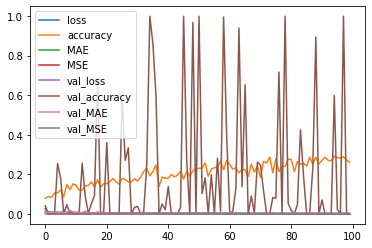

In [20]:
losses = pd.DataFrame(history.history)
losses.plot()

### Evaluation on Test Data

In [21]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [22]:
predictions = model.predict(X2)

print(f"Mean Absolute Error: {mean_absolute_error(Y2.values,predictions)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(Y2.values,predictions))}")


Mean Absolute Error: 0.0014764575867441268
Mean Squared Error: 0.0018262290248297135


In [21]:
print(Y2.shape,type(Y2))
print(np.shape(Y2[10][0:144]))
print(predictions.shape, type(predictions))
print(np.shape(predictions[: , 10]))
type(Y2.values)

(30000, 40) <class 'pandas.core.frame.DataFrame'>
(144,)
(30000, 40) <class 'numpy.ndarray'>
(30000,)


numpy.ndarray

In [40]:
for i in [5,22,65,100,200]:
    t = np.arange(144)
    bar = 5
    plt.figure(figsize = (13,4.5), dpi = 300)
    plt.plot(t,predictions[(i*144):((i*144)+144), bar], 'y', label = 'Predictions')
    plt.plot(t,Y2.values[(i*144):((i*144)+144), bar], 'r', label = 'Dataset')
    plt.show
    plt.xticks(np.arange(0, 145, 12), ('0h', '2h', '4h', '6h', '8h', '10h', '12h', '14h','16h', '18h', '20h', '22h', '24h'))
    plt.ylim(0.99, 1.05)
    plt.title(f'Voltage Bar{bar} - Day {i} - With P/Q/V as Input')
    plt.legend(loc='upper right', prop={'size': 10}, framealpha=1)
    plt.savefig(f"Bar{bar}/Voltage_Bar{bar}_Day{i}_PQV.jpg")
    plt.close()


In [24]:
model.save('70train_150batch_100epochs_withVoltages.h5')
